In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from __future__ import print_function

%matplotlib inline

In [2]:
def get_sequence(work_dir,prmtop_name,nc_file):
        
    traj = md.load_netcdf(work_dir+nc_file, top=work_dir+prmtop_name, stride = None)

    res_list = []
    for res in traj.topology.residues:
        res_list.append(res)

    res_list_strings = []

    for res in res_list:
        res_list_strings.append(str(res))
    
    return res_list_strings

In [3]:
def helicity_calculator(work_dir,prmtop_name,nc_file,increment):
    
    traj = md.load_netcdf(work_dir+nc_file, top=work_dir+prmtop_name, stride = None)
    traj = traj[:increment]

    res_list = []
    for res in traj.topology.residues:
        res_list.append(res)

    res_list_strings = []

    for res in res_list:
        res_list_strings.append(str(res))

    peptide_length=len(res_list)

    sec_struct = md.compute_dssp(traj, simplified = True)
    frames = len(sec_struct)

    idx = 0
    struct_list=[]
    resid_list=[]

    for idx in range(0, peptide_length):
        for frame in sec_struct:
            resid_list.append(frame[idx])
        struct_list.append(resid_list)
        resid_list=[]

    count = 0
    helicity_per_residue = []
    helicity = 0

    for res in struct_list:
        if 'NA' in res:
            empty = 1 
        else:
            for snapshot in res:
                if snapshot == 'H':
                    count+=1
                helicity = (count/frames)*100
            helicity_per_residue.append(helicity)
            count=0
        
    return helicity_per_residue


In [4]:
def auc_calculator(helicity):
    auc = np.trapz(helicity, dx=1)

    return auc

In [ ]:
# create reference helicity plot for 100% helicity, the termini should have 0% helicity
# the length of the list should be equal to the length of the peptide

reference_helicity = [0.0,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 0.0]

ref_auc = np.trapz(reference_helicity, dx=1)

In [ ]:
work_dirs = ['./', './replicate-2/', './replicate-3/']

In [7]:
prmtop_name = 'dry.prmtop'
nc_file = "prod_dry.nc"

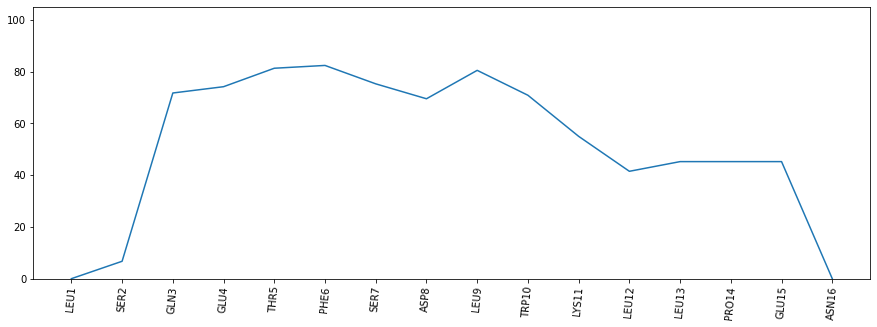

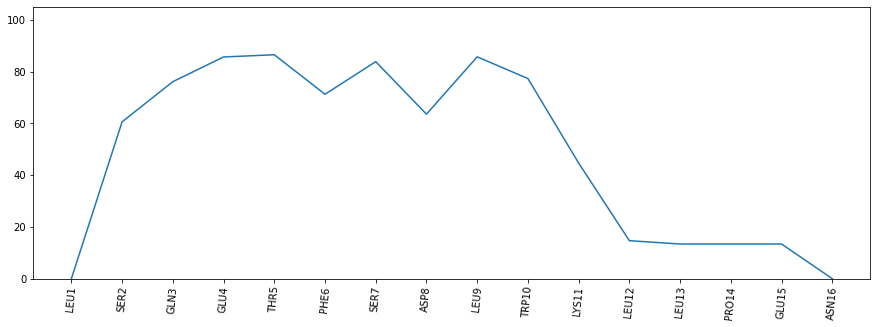

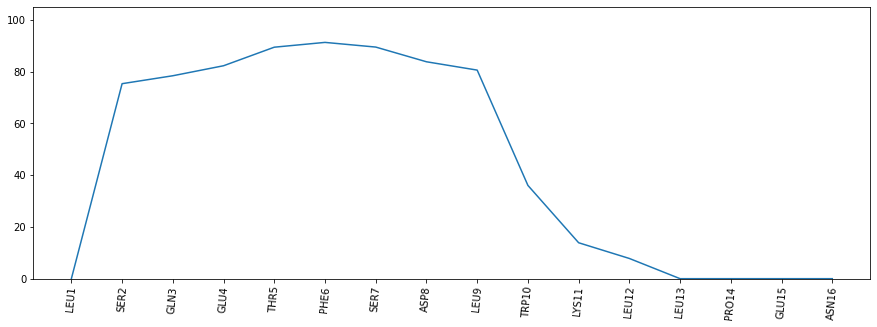

In [8]:


for work_dir in work_dirs:

    helicity_list = helicity_calculator(work_dir=work_dir,prmtop_name=prmtop_name,nc_file=nc_file,increment=None)
    auc = auc_calculator(helicity_list)
    sequence = get_sequence(work_dir=work_dir,prmtop_name=prmtop_name,nc_file=nc_file)

    fig,ax = plt.subplots()
    ax.plot(sequence[1:-1], helicity_list) 

    plt.xticks(rotation=85)

    ax.set_ylim([0.0, 105.0])
    plt.gcf().set_size_inches(15,5)

    plt.show()

In [9]:
replicates_helicity = []
replicates_auc = []

for work_dir in work_dirs:
    print(work_dir)

    increments = range(100, 20001, 100) 

    all_helicity_results = []

    for inc in increments:
        helicity = helicity_calculator(work_dir, prmtop_name, nc_file, inc)
        all_helicity_results.append(helicity)

    auc_list = []

    for hel in all_helicity_results:
        auc = auc_calculator(hel)

        auc_list.append(auc)
    
    replicates_helicity.append(all_helicity_results)
    replicates_auc.append(auc_list)

./
./replicate-2/
./replicate-3/


In [10]:
replicates_percent_helicity = []

for replica_auc in replicates_auc:
    percent_helicity = []

    for auc in replica_auc:
        percent_helicity.append((auc/ref_auc)*100)

    replicates_percent_helicity.append(percent_helicity)

In [11]:
# one frame is 0.01 ns

time = range(1, 201, 1) 


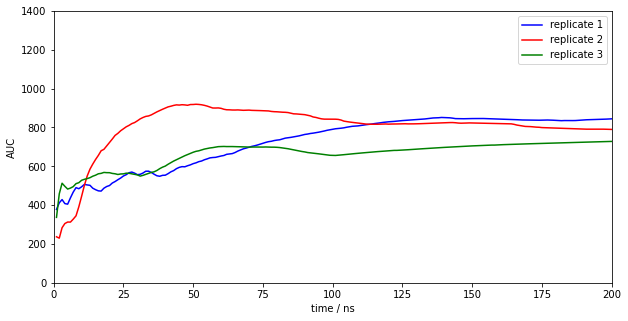

In [12]:

plt.figure(figsize=(10, 5))
plt.plot(time, replicates_auc[0], marker='', linestyle='-', color='b', markersize=3, label="replicate 1")
plt.plot(time, replicates_auc[1], marker='', linestyle='-', color='r', markersize=3, label="replicate 2")
plt.plot(time, replicates_auc[2], marker='', linestyle='-', color='g', markersize=3, label="replicate 3")

# Labels and title
plt.xlabel("time / ns")
plt.ylabel("AUC")

plt.legend()
#ßplt.grid(True)
plt.xlim([0.0, 200.0])
plt.ylim([0.0, 1400.0])

plt.rcParams['figure.dpi'] = 300
fig.savefig(work_dirs[0]+'auc.png', bbox_inches='tight')
plt.show()


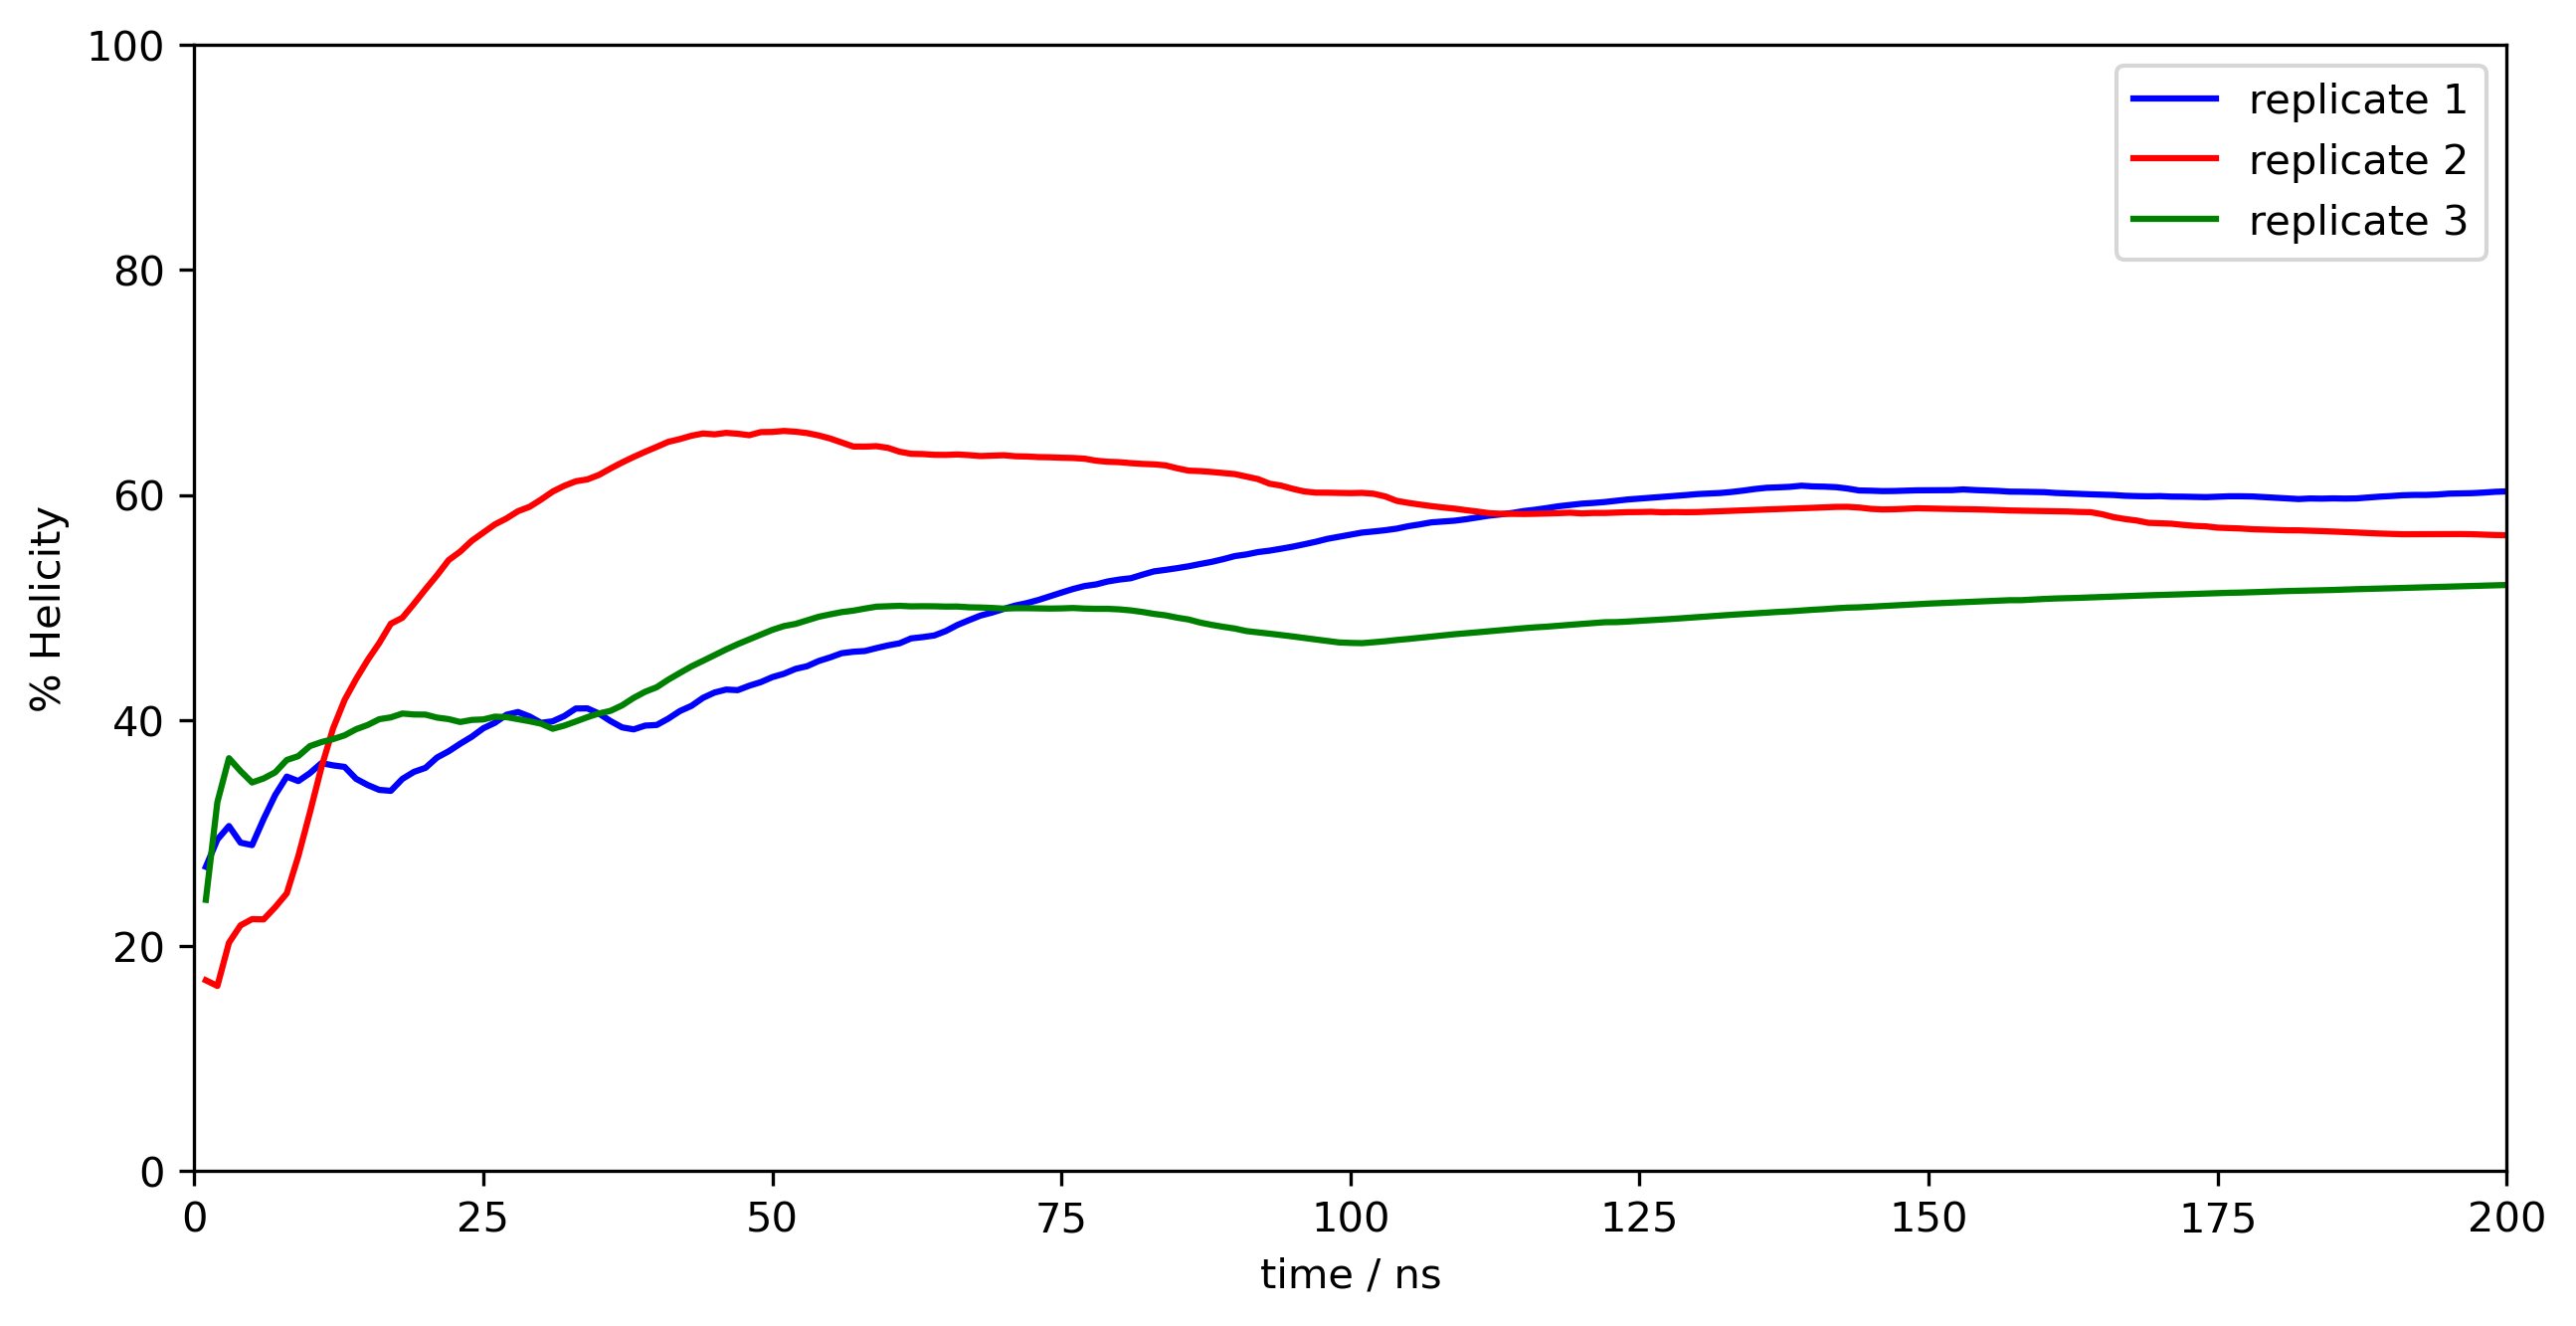

In [13]:

plt.figure(figsize=(10, 5))
plt.plot(time, replicates_percent_helicity[0], marker='', linestyle='-', color='b', markersize=3, label="replicate 1")
plt.plot(time, replicates_percent_helicity[1], marker='', linestyle='-', color='r', markersize=3, label="replicate 2")
plt.plot(time, replicates_percent_helicity[2], marker='', linestyle='-', color='g', markersize=3, label="replicate 3")

# Labels and title
plt.xlabel("time / ns")
plt.ylabel("% Helicity")

plt.legend()
#plt.grid(True)
plt.xlim([0.0, 200.0])
plt.ylim([0.0, 100.0])

plt.rcParams['figure.dpi'] = 300
fig.savefig(work_dirs[0]+'helicity.png', bbox_inches='tight')
plt.show()


In [14]:
data = np.array([replicates_percent_helicity[0], replicates_percent_helicity[1], replicates_percent_helicity[2]])  

average_list = np.mean(data, axis=0)

std_err_list = np.std(data, axis=0)/np.sqrt(len(work_dirs))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


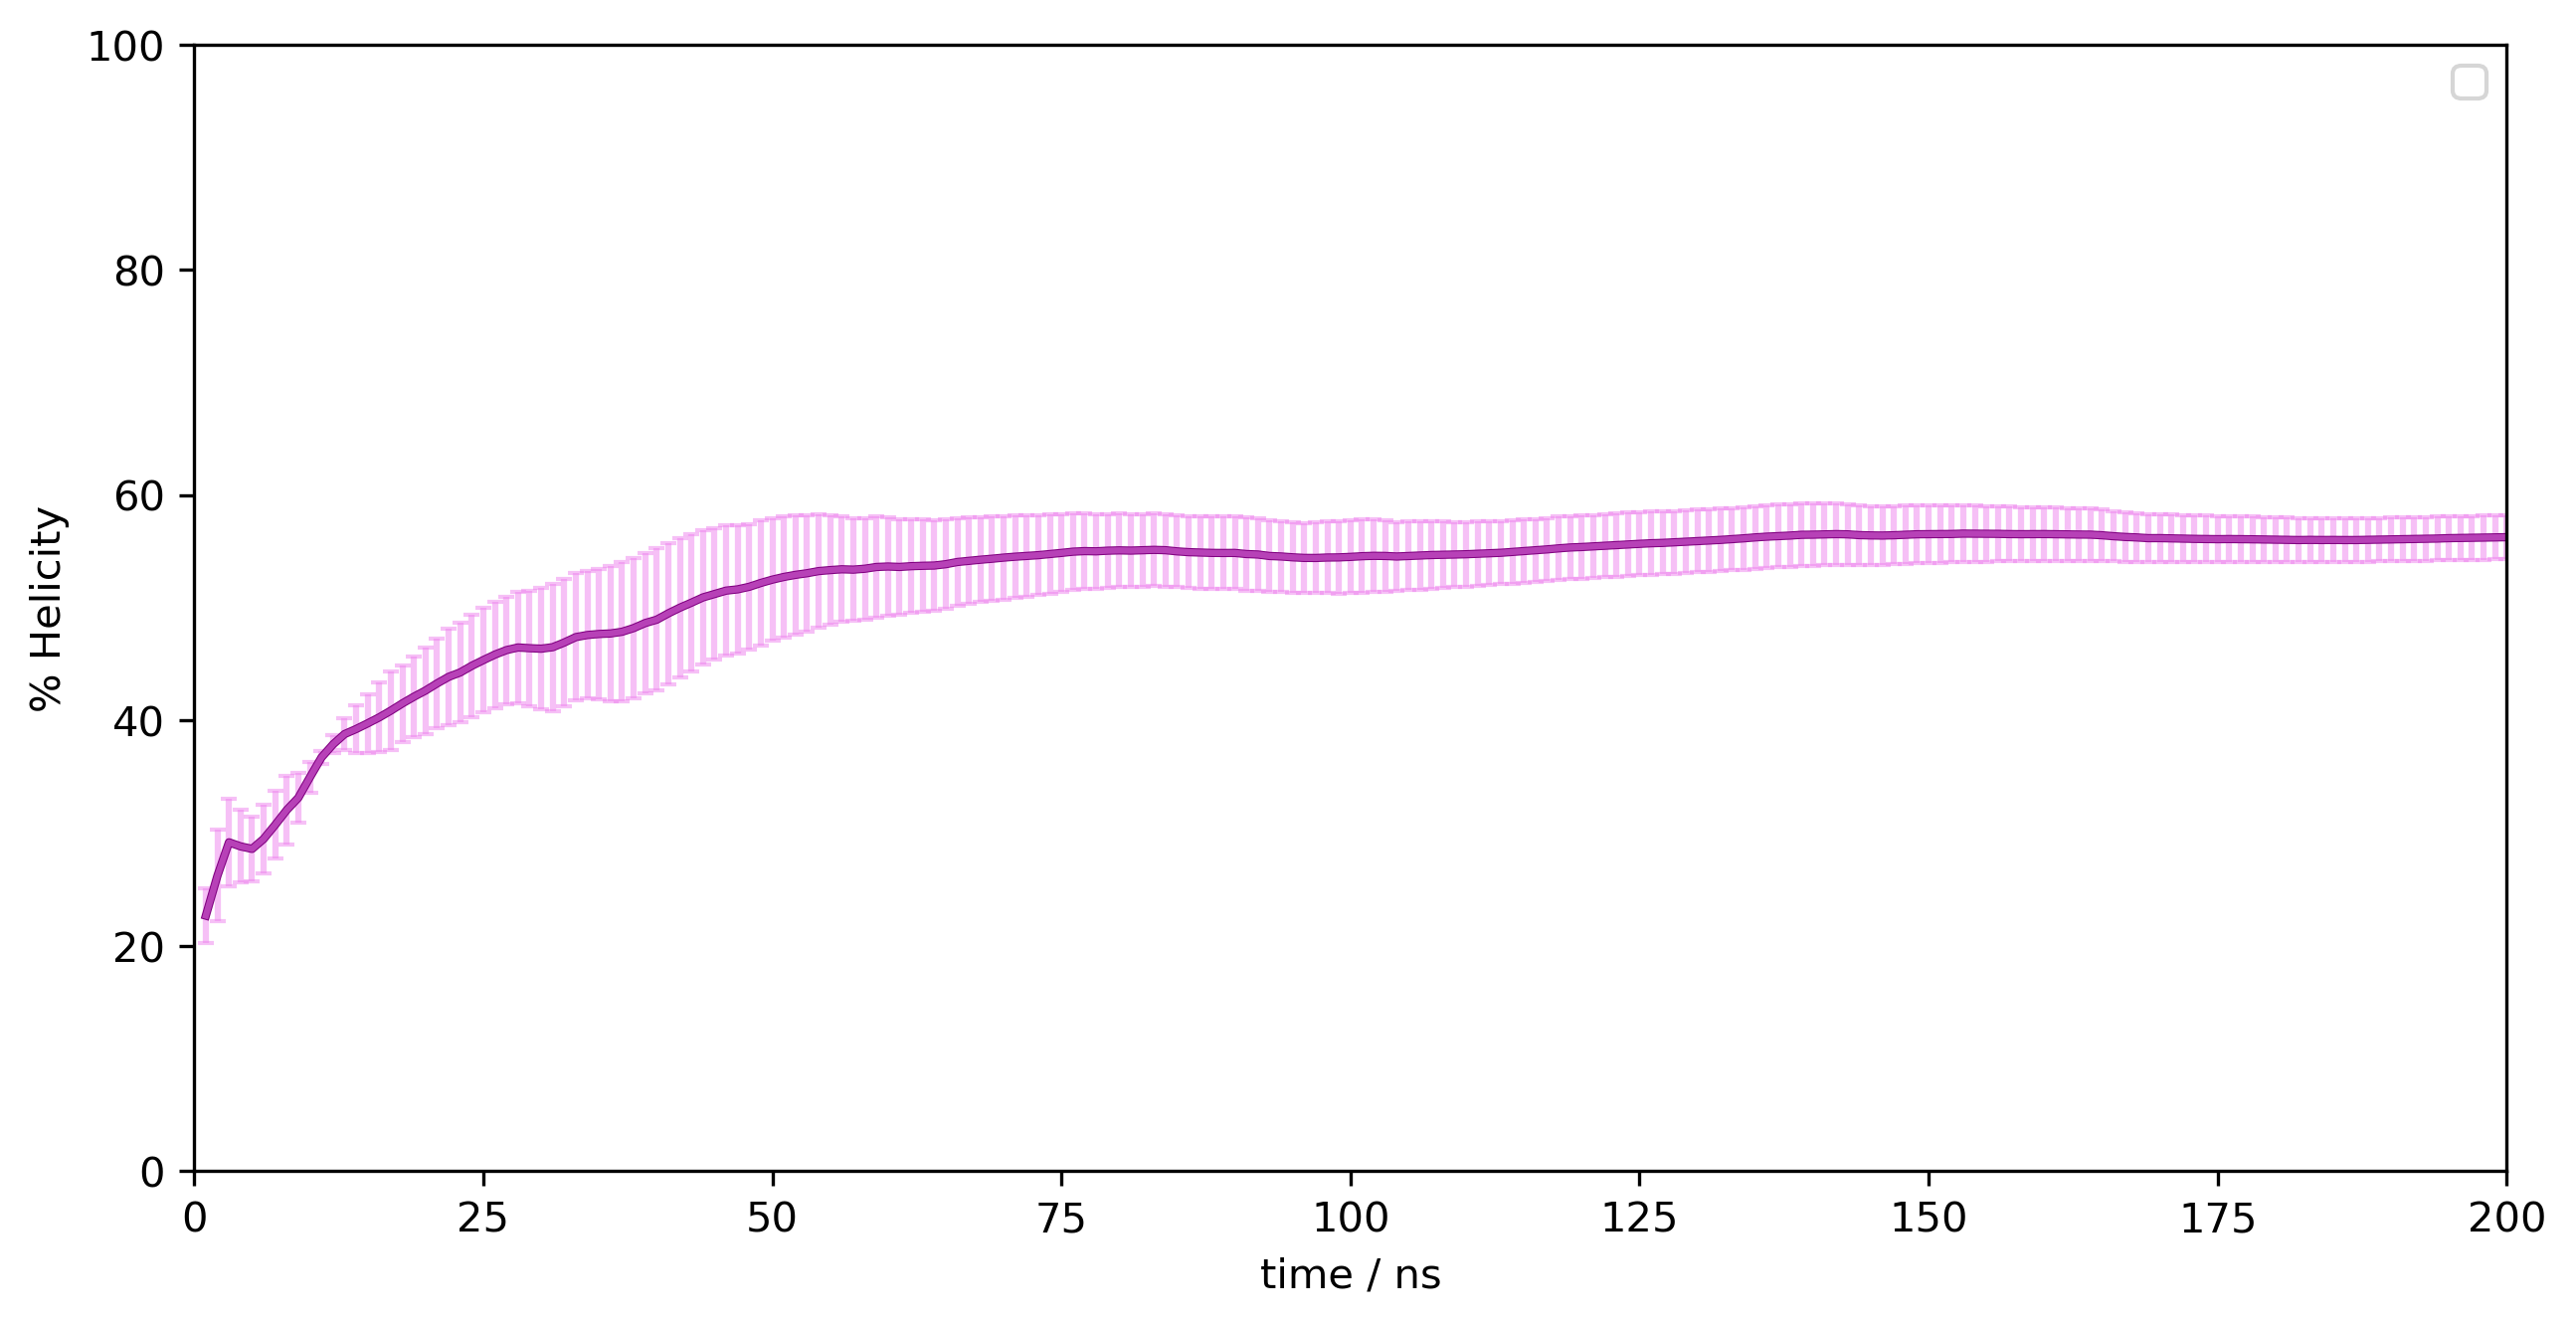

In [15]:
plt.figure(figsize=(10, 5))

plt.errorbar(time, average_list, yerr=std_err_list, fmt='', color='violet', alpha=0.5, capsize=2)
plt.plot(time, average_list, color="purple", linewidth=2)

# Labels and title
plt.xlabel("time / ns")
plt.ylabel("% Helicity")

plt.legend()
#plt.grid(True)
plt.xlim([0.0, 200.0])
plt.ylim([0.0, 100.0])

plt.rcParams['figure.dpi'] = 300
fig.savefig(work_dirs[0]+'avg_helicity.png', bbox_inches='tight')
plt.show()

In [19]:
print('% Helicity:', average_list[-1], "+-", std_err_list[-1])

% Helicity: 56.258452380952384 +- 1.9594588771089023
